# Visualize Citoid evaluation results

This is an interactive notebook that allows to consult the results of the evaluation of [Citoid](https://www.mediawiki.org/wiki/Citoid) for the [Web2Cit-Research](https://meta.wikimedia.org/wiki/Web2Cit/Research) project.

__Usage:__

First, run the cells to load the data and the functions. Then, interact with the widgets to visualize plots and samples.

__Author:__

* Nidia Hernández, [nidiahernandez@conicet.gov.ar](mailto:nidiahy@gmail.com), [CAICYT-CONICET](http://www.caicyt-conicet.gov.ar/sitio/) (Argentina)


## Table of Contents

0. Load evaluation results 
1. Show samples of best, middle and low scores
2. Strict vs relaxed scores
3. Filter by language
4. Filter by field
5. Results by domain

In [2]:
import os
import pandas as pd
import gzip
from glob import glob
from pprint import pprint
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

## 0. Load evaluation results

We have evaluated 321k citations, comparing the metadata returned by Citoid with the metadata of a manual citation for the following information: source type, title, author (first name(s) and last names(s)), publishig source and publishing date. 

The results of the comparison are in the columns beginning with the prefix "comp_".

In [3]:
results = pd.read_csv("eval/eval_all_citations.csv.gz")

In [4]:
results.shape

(91338, 25)

In [5]:
results.head()

,url,url_citoid,source_type_citoid,title_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid,citation_template,source_type_manual,...,article_url,page_id,revid,wiki_lang,comp_title,comp_source_type,comp_pub_source,comp_pub_date,comp_author_first,comp_author_last
0,https://www.theage.com.au/entertainment/movies...,https://www.theage.com.au/entertainment/movies...,webpage,bollywood on bourke street,NaN,NaN,2005-05-13,the age,cite news,"['magazineArticle', 'newspaperArticle']",...,https://en.wikipedia.org/wiki/Preity%20Zinta,415405,1070334117,en,1.00,0,0.00,1.0,1.0,0.00
1,https://books.google.com/books?id=QSwEAAAAMBAJ...,https://books.google.com/books?id=QSwEAAAAMBAJ...,book,vibe,['vibe media'],['group'],1997-01,vibe media group,cite magazine,[],...,https://en.wikipedia.org/wiki/House%20of%20Music,18386478,1053326252,en,0.05,0,1.00,0.0,0.2,0.12
2,https://www.ecaho.org/about-ecaho/about-us,https://www.ecaho.org/about-ecaho/about-us,webpage,about ecaho - ecaho,NaN,NaN,NaN,www.ecaho.org,Lien web,"['blogPost', 'email', 'forumPost', 'podcast', ...",...,https://fr.wikipedia.org/wiki/Arabe%20%28cheva...,354491,186027366,fr,0.58,1,1.00,1.0,1.0,1.00
3,https://www.gq.com/story/pacific-rim-uprising-...,https://www.gq.com/story/pacific-rim-uprising-...,webpage,the 'pacific rim uprising' director tells us a...,['conde'],['nast'],2018-03-23,gq,cite web,"['blogPost', 'email', 'forumPost', 'webpage']",...,https://en.wikipedia.org/wiki/The%20Thing%20%2...,30809,1070729737,en,0.22,1,1.00,1.0,0.2,0.17
4,http://bgtfans.com/2013/fifth-falcons-fury-tow...,http://bgtfans.com/2013/fifth-falcons-fury-tow...,webpage,NaN,NaN,NaN,NaN,bgtfans.com,cite web,"['blogPost', 'email', 'forumPost', 'webpage']",...,https://en.wikipedia.org/wiki/Falcon%27s%20Fury,39650109,1055267199,en,0.00,1,0.55,0.0,1.0,1.00


## 1. Show samples of best, middle and low scores

In this section, you can inspect the data and the evaluation results filtered by fieldname. The first menu allows to select the number of samples to retrieve. The second menu, the field to consult. 

The output shows samples of data and scoring using a relaxed match: best scored cases appear on top (70-100% coincidence), middle scores in the center (40-70% coincidence) and low scores at the bottom (less than 40%). There response from Citoid is displayed at left, the attended response is at the center, and the score is presented at right.

In [6]:
fieldnames = [
    "source_type", "title",
    "author_first", "author_last",
    "pub_source", "pub_date",
]

In [7]:
pd.set_option("colwidth", 200)

def show_samples(n, fieldname):
    discrete_scores = fieldname in ["source_type", "pub_date"]

    best_max = 1 if discrete_scores else 0.9
    
    ## Best scores
    display(results[
        (0.7 < results[f"comp_{fieldname}"]) &
        (results[f"comp_{fieldname}"] <= best_max) ## do not show None vs None cases
    ][[f"{fieldname}_citoid", f"{fieldname}_manual", f"comp_{fieldname}"]].sample(n))

    ## Mostrar el 0.7 de pub date!
    if not discrete_scores:
        ## Middle scores
        display(results[
            (0.4 < results[f"comp_{fieldname}"]) &
            (results[f"comp_{fieldname}"] <= 0.7)
        ][[f"{fieldname}_citoid", f"{fieldname}_manual", f"comp_{fieldname}"]].sample(n))

    ## Low scores
    display(results[
        #(0.1 < results[f"comp_{fieldname}"]) & ## do not show all 0
        (results[f"comp_{fieldname}"] < 0.4)
    ][[f"{fieldname}_citoid", f"{fieldname}_manual", f"comp_{fieldname}"]].sample(n))
    
interact(show_samples, n=[5, 10, 15], fieldname=fieldnames)

,source_type_citoid,source_type_manual,comp_source_type
36251,blogPost,"['blogPost', 'email', 'forumPost', 'webpage']",1
52392,webpage,"['blogPost', 'email', 'forumPost', 'webpage']",1
6789,webpage,"['blogPost', 'email', 'forumPost', 'webpage']",1
45490,webpage,"['blogPost', 'email', 'forumPost', 'webpage']",1
9818,webpage,"['blogPost', 'email', 'forumPost', 'webpage']",1


,source_type_citoid,source_type_manual,comp_source_type
25494,webpage,"['magazineArticle', 'newspaperArticle']",0
53391,journalArticle,"['blogPost', 'email', 'forumPost', 'webpage']",0
30318,webpage,"['magazineArticle', 'newspaperArticle']",0
69795,webpage,"['magazineArticle', 'newspaperArticle']",0
9377,webpage,"['magazineArticle', 'newspaperArticle']",0


<function __main__.show_samples(n, fieldname)>

## 2. Strict vs window scoring

In this section, you can inspect the proportion of each match type for each fieldname. You can select strict or window scoring. The strict scoring considers a fullmatch only for 100% coincidence and no match for 0% coincidence. The window scoring admits full match starting at 70% but considers no match from 40% to lower.

In [8]:
## Strict scoring 
# full_match: 100% match (score == 1)
# no_match: score == 0
# partial_match: the rest

rows = []

total = len(results)

for fieldname in fieldnames:
    full_match = len(results[ results[f"comp_{fieldname}"] == 1 ])
    no_match = len(results[ results[f"comp_{fieldname}"] == 0])
    partial_match = total - full_match - no_match
    
    row = {"full_match":round(full_match/total,2), "partial_match":round(partial_match/total,2), "no_match": round(no_match/total,2)}
    rows.append(row)
    
totals_strict = pd.DataFrame(rows)
totals_strict.index = fieldnames

#totals_strict

In [9]:
totals_strict.mean(axis=0).round(2) * 100

full_match       54.0
partial_match    21.0
no_match         25.0
dtype: float64

In [10]:
## Window scoring
# full_match: score > 0.7
# partial_match:  0.7 >= score > 0.3
# no_match: score > 0.3


fieldnames = [
    "source_type", "title",
    "author_first", "author_last",
    "pub_source", "pub_date",
]

rows = []

total = len(results)

for fieldname in fieldnames:
    #print(fieldname)
    full_match = len(results[ results[f"comp_{fieldname}"] > 0.7 ])
    
    no_match = len(results[ results[f"comp_{fieldname}"] <= 0.3])
    
    partial_match = total - full_match - no_match
    
    row = {"full_match":round(full_match/total,2), "partial_match":round(partial_match/total,2), "no_match": round(no_match/total,2)}
    rows.append(row)
    
totals_window = pd.DataFrame(rows)
totals_window.index = fieldnames

#totals_window

In [10]:
totals_window.mean(axis=0).round(2) * 100

full_match       48.0
partial_match     8.0
no_match         44.0
dtype: float64

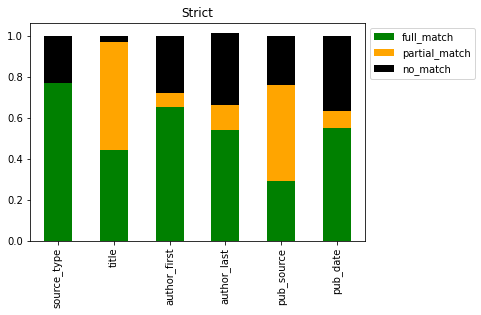

,full_match,partial_match,no_match
source_type,0.77,0.00,0.23
title,0.44,0.53,0.03
author_first,0.65,0.07,0.28
author_last,0.54,0.12,0.35
pub_source,0.29,0.47,0.24
pub_date,0.55,0.08,0.37


<function __main__.plot_stacked_ratios(key)>

In [11]:
def plot_stacked_ratios(key):

    colors = ["Green", "Orange", "Black"]

    df = {
        "Strict": totals_strict,
        "Window": totals_window,
    }[key]

    ax = df.plot.bar(stacked=True, color=colors, title=key)
    ax.legend(bbox_to_anchor=(1, 1))
    
    plt.show()
    
    display(df)
    

interact(
    plot_stacked_ratios,
    key=["Strict", "Window"],
)

## 3. Filter by language

In this section, the user can filter the data by the language of the wikipedia and compare the results between fields (strict scoring only).

In [12]:
comp_cols = [f"comp_{field}" for field in fieldnames]

data_per_lang = pd.concat([
    (results.set_index("wiki_lang")[comp_cols] == 1).groupby("wiki_lang").mean().assign(match_type="full match"),
    (~results.set_index("wiki_lang")[comp_cols].isin({0, 1})).groupby("wiki_lang").mean().assign(match_type="partial match"),
    (results.set_index("wiki_lang")[comp_cols] == 0).groupby("wiki_lang").mean().assign(match_type="no match")
]).round(2).sort_values(by="wiki_lang").reset_index().set_index(["wiki_lang", "match_type"]).transpose()
data_per_lang.index = fieldnames

data_per_lang

wiki_lang            en                                es                \
match_type   full match partial match no match full match partial match   
source_type        0.66          0.00     0.34       0.78          0.00   
title              0.31          0.67     0.02       0.25          0.72   
author_first       0.50          0.07     0.43       0.57          0.05   
author_last        0.45          0.15     0.40       0.41          0.17   
pub_source         0.22          0.54     0.25       0.18          0.50   
pub_date           0.37          0.14     0.49       0.42          0.10   

wiki_lang                     fr                                pt  \
match_type   no match full match partial match no match full match   
source_type      0.22       0.90          0.00     0.10       0.82   
title            0.03       0.20          0.78     0.02       0.30   
author_first     0.38       0.79          0.01     0.21       0.65   
author_last      0.41       0.55          0.09     0.36       0.46   
pub_source       0.32       0.17          0.58     0.25       0.20   
pub_date         0.47       0.57          0.06     0.37       0.44   

wiki_lang                            
match_type   partial match no match  
source_type           0.00     0.18  
title                 0.66     0.04  
author_first          0.03     0.32  
author_last           0.13     0.41  
pub_source            0.49     0.31  
pub_date              0.07     0.48

In [13]:
colors = {
    "full match": "Green",
    "partial match": "Orange",
    "no match": "Black"
}

def plot_stacked_ratios(lang):
    # data_per_lang esta definido afuera
    data_for_plot = data_per_lang.loc[:, lang]
    ax = data_for_plot.plot.bar(stacked=True, color=colors, title=lang)
    ax.legend(bbox_to_anchor=(1, 1))
    
    plt.show()
    display(data_for_plot)

interact(
    plot_stacked_ratios,
    lang=results["wiki_lang"].unique(),
)

interactive(children=(Dropdown(description='lang', options=('en', 'es', 'pt', 'fr'), value='en'), Output()), _…

<function __main__.plot_stacked_ratios(lang)>

## 4. Filter by field

In this section, the user can filter the data by fieldname and compare the results between different Wikipedias (stric scoring only).

In [14]:
def plot_field_by_lang(field):
    df = data_per_lang.loc[field].reset_index().pivot_table(index="wiki_lang", columns="match_type", values=field)
    ax = df.plot.bar(stacked=True, color=colors, title=field)
    ax.legend(bbox_to_anchor=(1, 1))
    
    plt.show()
    display(df)
    
interact(
    plot_field_by_lang,
    field=fieldnames,
)

interactive(children=(Dropdown(description='field', options=('source_type', 'title', 'author_first', 'author_l…

<function __main__.plot_field_by_lang(field)>

## 5. Results by domain

In this section, the user can filter the data by top domains (5, 10 or 15) and obsrve the average results for  all languages or for each language.

In [12]:
## Find domains from URLs
comp_cols = [f"comp_{field}" for field in fieldnames]
results_lang_url = results[["wiki_lang", "url", "url_citoid"]+comp_cols].copy()

def find_domain(s):
    if s.startswith("http"):
        domain = s.split("/")[2].replace("www.", "")
    else:
        domain = False
    return domain

results_lang_url["domain"] = results_lang_url["url"].map(find_domain)
domains = results_lang_url[results_lang_url["domain"].map(bool)]

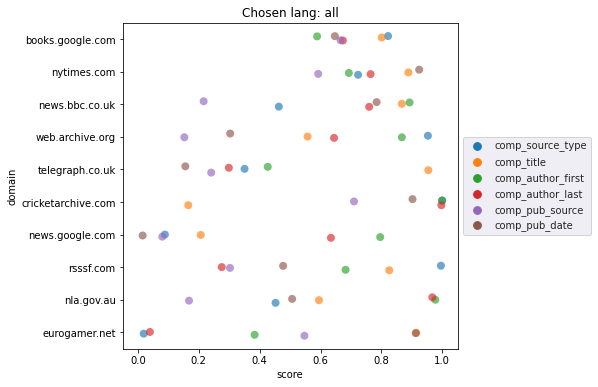

<function __main__.plot_top_domains_performance(lang='all', n=10)>

In [13]:
def plot_top_domains_performance(lang="all", n=10):
    ## Find top n domains (all languages)
    if lang == "all":
        selected_domains = domains
    else:
        selected_domains = domains[ domains["wiki_lang"] == lang ]

    domain_count = selected_domains[["domain"]].value_counts()
    domain_count.name = "count"
    domain_count = domain_count.reset_index()
    domain_count = domain_count.sort_values(by=["count"], ascending=False)
    top_domains = domain_count.head(n)
    top_domains

    domain_order = top_domains["domain"].tolist()
    mask = selected_domains["domain"].isin(domain_order)

    ## Results mean by domain
    results_mean_by_url = selected_domains[mask].groupby("domain").mean()
    results_mean_by_url = results_mean_by_url.reindex(index=domain_order)
    results_mean_by_url

    means_tidy = results_mean_by_url.reset_index().melt(id_vars="domain", var_name="fieldname", value_name="score")

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sns.set_style("darkgrid")

    sns.stripplot(
        data=means_tidy,
        x="score",
        y="domain",
        hue="fieldname",
        s=8,
        alpha=0.65,
        ax=ax
    )

    ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    ax.set_title(f"Chosen lang: {lang}")
    ax.set_xlim(-0.05, 1.05)
    
    
interact(
    plot_top_domains_performance,
    lang=["all", "en", "es", "fr", "pt"],
    n=[5, 10, 15],
)